In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.predict(dataset_params = {
    'from': '2018-07-01',
    'to': '2018-12-31',
    'categories': ['PLAT']
}, model_params = {
    'kfolds': 3,
    'nan_flag': 100000,
    'n_targets': 2
})

preparing model data
preparing stacked model data


In [4]:
len(program.df)

17194

In [5]:
df = program.df

In [6]:
def bet(df, features, categorical_features, targets, N=1, max_odds=20, break_on_bet=True, break_on_odds=False):

    races = df.sort_values('start_at').groupby('race_id')

    bets = []

    for (id, race) in races:

        candidate_bets = []

        nums = []

        for target in targets:

            r = race.sort_values(by=target, ascending=False)

            if len(r) <= N:
                break
                
            NN = N

            for n in range(NN):

                player = r.iloc[n]

                odds = player['final_odds_ref']

                if max_odds is not None and odds > max_odds:
                    if break_on_odds:
                        break
                    else:
                        continue

                nth = (r['final_odds_ref']<odds).sum()+1
                
                #bet = np.clip(np.abs(player[target])/100.0, 0, 10)
                
                #bet = np.round(1+bet) * 1.5
                
                #if bet <= 0:
                #    break
                
                if n+1 < len(r) and r.iloc[n+1][target] == player[target]:
                    NN = NN+1
                    
                bet = 1

                profit = player['winner_dividend']/100.0 * bet - bet
                profit_placed = player['placed_dividend']/100.0 * bet - bet

                row = [id, player['start_at'], player['num'], player['position'], n, odds, player['final_odds'], target, player[target], r[target].std(), bet, profit, profit_placed]

                for nn in range(1,4):
                    if n+nn < len(r):
                        row.append(r.iloc[n+nn][target])
                    else:
                        row.append(np.nan)

                for f in features:
                    row.append(player[f])
                for f in categorical_features:
                    row.append(player[f])

                candidate_bets.append( row )

                nums.append(player['num'])

                if break_on_bet:
                    break

        #if len(candidate_bets) == 1:
        #    bets += candidate_bets
        bets += candidate_bets

    cols = ['id', 'date', 'num', 'pos', 'nb', 'odds_ref', 'odds_final', 'target', 'pred', 'pred_std', 'bet', 'profit', 'profit_placed']

    for nn in range(1,4):
        cols.append('next_pred_{}'.format(nn))

    cols = cols + features + categorical_features

    bets = pd.DataFrame(bets, columns=cols)
    bets['date'] = pd.to_datetime(bets['date'])

    bets = bets.set_index(bets['date'])
    bets = bets.sort_index()

    bets['bets'] = bets['bet'].cumsum()
    bets['stash'] = bets['profit'].cumsum()

    return bets



In [9]:
#exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'pred_stacked'] + ['pred_stacked_{}'.format(pos+1) for pos in range(1,8)] + ['pred_xgb_100_1', 'pred_rf_100_1', 'pred_knn_5_1', 'pred_mlp_100_1', 'pred_ridge_1_1']).sort_values(by='pred_stacked_8', ascending=False)
exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'target_pos'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]).sort_values(by='position', ascending=True)



position  declared_player_count sub_category  num  final_odds  \
race_id                                                                       
22895   4569       1.0                     11     HANDICAP    5         4.1   
        4571       2.0                     11     HANDICAP    7         3.1   
        4565       3.0                     11     HANDICAP    1         6.8   
        4573       4.0                     11     HANDICAP    9        30.6   
        4566       5.0                     11     HANDICAP    2         6.4   
        4568       6.0                     11     HANDICAP    4        18.1   
        4570       7.0                     11     HANDICAP    6        18.8   
        4572       8.0                     11     HANDICAP    8        12.3   
        4567       9.0                     11     HANDICAP    3        18.4   
        4575      10.0                     11     HANDICAP   11        81.4   
        4574      11.0                     11     HANDICAP   10        77.3   

              final_odds_ref  target_pos  pred_xgb_10_1  pred_xgb_30_1  \
race_id                                                                  
22895   4569             4.9           1       0.108627       0.076604   
        4571             8.0           1       0.130028       0.120137   
        4565            18.2           1       0.096249       0.049633   
        4573             3.9           2       0.100245       0.067565   
        4566            19.9           2       0.121549       0.110618   
        4568            29.2           2       0.120612       0.101909   
        4570             5.5           2       0.123250       0.096560   
        4572             8.6           2       0.127224       0.108280   
        4567            24.3           2       0.126551       0.114840   
        4575             9.3           2       0.113175       0.083945   
        4574        100000.0           2       0.101158       0.061641   

              pred_xgb_100_1  pred_knn_1_1  pred_knn_2_1  pred_knn_3_1  \
race_id                                                                  
22895   4569        0.088254      0.333333      0.333333      0.222222   
        4571        0.138322      0.000000      0.000000      0.000000   
        4565        0.041331      0.000000      0.000000      0.111111   
        4573        0.055379      0.000000      0.166667      0.111111   
        4566        0.094630      0.000000      0.000000      0.000000   
        4568        0.099990      0.333333      0.166667      0.111111   
        4570        0.108496      0.000000      0.000000      0.000000   
        4572        0.114652      0.000000      0.000000      0.000000   
        4567        0.123611      0.333333      0.166667      0.111111   
        4575        0.045588      0.000000      0.000000      0.000000   
        4574        0.052807      0.000000      0.000000      0.000000   

              pred_knn_4_1  pred_knn_5_1  pred_knn_6_1  pred_knn_7_1  \
race_id                                                                
22895   4569      0.166667      0.200000      0.166667      0.190476   
        4571      0.000000      0.000000      0.055556      0.047619   
        4565      0.083333      0.066667      0.055556      0.095238   
        4573      0.083333      0.066667      0.111111      0.142857   
        4566      0.000000      0.000000      0.000000      0.000000   
        4568      0.083333      0.066667      0.111111      0.142857   
        4570      0.000000      0.000000      0.000000      0.047619   
        4572      0.083333      0.133333      0.111111      0.095238   
        4567      0.083333      0.066667      0.055556      0.047619   
        4575      0.000000      0.000000      0.000000      0.000000   
        4574      0.000000      0.000000      0.000000      0.047619   

              pred_knn_8_1  pred_knn_9_1  pred_knn_10_1  \
race_id                                                   
22895

In [8]:
df = program.df
df['pred_rnd'] = np.random.rand(df.shape[0])
df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)

'''
for model in program.model.models:
    df['pred_{}_1_3'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(1,4) ] ].sum(axis=1)
    df['pred_{}_2_4'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(2,5) ] ].sum(axis=1)
'''

'''
for model in program.model.models:
    df['pred_minus_ref_{}'.format(model['name'])] = df['pred_{}_1'.format(model['name'])] - df['final_odds_ref']
    
for model in program.model.stacked_models:
    df['pred_minus_ref_stacked_{}'.format(model['name'])] = df['pred_stacked_{}_1'.format(model['name'])] - df['final_odds_ref']
'''


bets = bet(df, program.model.features, program.model.categorical_features, 
    N=6, max_odds=None, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_{}'.format(model['name'], i+1) for i in range(program.model.params['n_targets']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models] 
   )

'''
bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]
   )
'''
    
    

"\nbets = bet(df, program.model.features, program.model.categorical_features, \n    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, \n    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]\n   )\n"

In [10]:
program.df.race_id.nunique()

1487

In [11]:
def graph_bb(bb, f):
    results = []

    for s in bb[f].value_counts().index:
        results = []
        x = bb[ (bb[f] == s) & (bb['pred_std'] != 0) & (bb['pred'] != 0) ].copy()
        if len(x) == 0:
            continue
        #print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))

        fig, axs = plt.subplots(1,1)

        for t in x['target'].value_counts().index:
            bbb = x[(x['target'] == t)].copy()
            #bbb = bbb[ (bbb['pred']>bbb['pred'].quantile(0.85)) ].copy()


            results.append({
                'idx_1': s,
                'idx_2': t,
                'profit': bbb.profit.sum(),
                'profit_place': bbb.profit_placed.sum(),
                'bet': bbb.bet.sum(),
                'bets': bbb.bet.count(),
                'avg': bbb.profit.sum() / bbb.bet.sum()
            })

            '''
            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            fig, axs = plt.subplots(1,1)
            bbb['stash'].plot(figsize=(6, 2))
            bbb['cbet'].plot(figsize=(6, 2))
            plt.show()
            '''

            #print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )

            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            bbb['stash'].plot(figsize=(10, 2))
            bbb['cbet'].plot(figsize=(10, 2))

        results = pd.DataFrame(results)
        results = results.set_index(['idx_1', 'idx_2'])
        print(results.sort_values(by='avg', ascending=False))


        plt.show()    

    
    

In [11]:
#countries = list(bets['country'].value_counts()[0:10].index)
#sub_categories = list(bets['sub_category'].value_counts()[0:10].index)

#%store countries
#%store sub_categories

In [32]:
%store -r params
%store -r countries
%store -r sub_categories

In [35]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

target = 'pred_knn_1_1'

c_min = bets[(bets['target'] == target)]['pred'].min()
c_mean = bets[(bets['target'] == target)]['pred'].mean()
c_max = bets[(bets['target'] == target)]['pred'].max()

space = [
          Real(1, 10, name='min_odds'),
          Real(10, 60, name='max_odds'),
          Real(c_min, c_mean, name='min_pred'),
          Real(c_mean, c_max, name='max_pred'),
          Integer(5, 25, name='max_players')] + [
          Integer(0,1, name='country_{}'.format(country)) for country in countries] + [
          Integer(0,1, name='sub_category_{}'.format(sub_category)) for sub_category in sub_categories] + [
          Integer(0,1, name='nb_{}'.format(n)) for n in range(0,6)]
         
def x_to_params(x):
    params = {}
    
    params['min_odds'] = x[0]
    params['max_odds'] = x[1]
    params['max_pred'] = x[3]
    params['min_pred'] = x[2]
    params['max_players'] = x[4]
    
    for i, country in enumerate(countries):
        params['country_{}'.format(country)] = x[5+i]
        
    for i, sc in enumerate(sub_categories):
        params['sub_category_{}'.format(sc)] = x[5+len(countries)+i]
        
    for n in range(0,6):
        params['nb_{}'.format(n)] = x[5+len(countries)+len(sub_categories)+n]

    return params

@use_named_args(space)
def f(**params):
    return ff(params)
    
def ff(params, train=True):
    
    print(params)
    
    b = bets[ (bets['pred'] != 0) & (bets['target']==target) & (bets['pred_std'] != 0)]
    
    b = b[ (b['odds_ref'] > params['min_odds']) & (b['odds_ref'] < params['max_odds']) & (b['declared_player_count'] > 1) & (b['declared_player_count'] <= params['max_players']) ]
    
    #b = b[(b['pred'] > params['min_pred']) & (b['pred'] < params['max_pred'])]
    
    for country in countries:
        if params['country_{}'.format(country)] == 0:
            b = b[ b['country'] != country ]
            
    for sub_category in sub_categories:
        if params['sub_category_{}'.format(sub_category)] == 0:
            b = b[ b['sub_category'] != sub_category ]
            
    for n in range(0,6):
        if params['nb_{}'.format(n)] == 0:
            b = b[ b['nb'] != n]
    
    p = b.profit.sum()
    pp = len(b[b['profit'] > 0])
    bet = b.bet.sum()
    
    print("{:+.2f} {:+.2f}\n".format(p, bet))
        
    if bet == 0:
        return 0
    
    if not train:
        return b
    
    return - (p)
    
    

In [14]:
#from skopt import dummy_minimize, gp_minimize, gbrt_minimize

#res = gbrt_minimize(f, space, n_calls=100)

In [15]:
#print(res.x, res.fun)

In [16]:
#params = x_to_params(res.x)
#%store params

In [17]:
len(program.model.models[0]['estimators'])
program.model.hash

'288e902a9cd69b8d95b9c3904340fb19'

In [36]:
bb = ff(params, False)

{'min_odds': 9.576347305144598, 'max_odds': 57.87900266957316, 'max_pred': 0.764210514645641, 'min_pred': 0.3539286272945729, 'max_players': 11, 'country_FRA': 1, 'country_DEU': 1, 'country_CHL': 0, 'country_GBR': 1, 'country_SGP': 0, 'country_ARE': 0, 'country_CHN': 0, 'country_BEL': 0, 'country_ARG': 1, 'country_URY': 1, 'sub_category_COURSE_A_CONDITIONS': 0, 'sub_category_HANDICAP': 1, 'sub_category_HANDICAP_DIVISE': 0, 'sub_category_A_RECLAMER': 0, 'sub_category_HANDICAP_CATEGORIE_DIVISE': 0, 'sub_category_HANDICAP_DE_CATEGORIE': 1, 'sub_category_GROUPE_III': 1, 'sub_category_GROUPE_I': 0, 'sub_category_GROUPE_II': 1, 'sub_category_COURSE_A_CONDITION_QUALIF_HP': 1, 'nb_0': 0, 'nb_1': 0, 'nb_2': 1, 'nb_3': 1, 'nb_4': 1, 'nb_5': 0}
-12.00 +69.00



                                       avg  bet  bets  profit  profit_place
idx_1 idx_2                                                                
PLAT  pred_stacked_mlp_relu_1    -0.140741  270   270   -38.0         -96.5
      final_odds_ref             -0.178734  395   395   -70.6         -95.0
      pred_sum                   -0.246667  315   315   -77.7         -93.5
      pred_stacked_mlp_sigmoid_1 -0.353704  324   324  -114.6         -71.5
      pred_rnd                   -0.429958  237   237  -101.9         -57.1


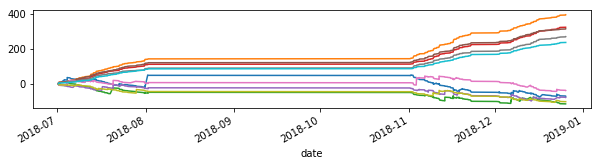

In [50]:
bb = bets[(bets['nb']==5) & (bets['odds_ref'] > 5) & (bets['odds_ref'] < 50) & (bets['sub_category']=='COURSE_A_CONDITIONS') & (bets['pred'] > 0.4) ]


#bb = bb.groupby('id').filter(lambda b: len(b) <3 )
#bb = bets[ ((bets['nb']==2) ) & (bets['target']!='fpred_stacked_mlp_relu_1') & (bets['odds_ref']<30) & (bets['odds_ref']>10) & (bets['pred']>0)]
#bb = bets[ ((bets['nb']==2) ) & (bets['target']!='fpred_knn_2_1') & (bets['odds_ref']<10) & (bets['odds_ref']>3) & (bets['pred']>0.1)]
#bb = bets[ (bets['country']!='dFRA') & (bets['sub_category']!='dNATIONALE_AUTOSTART') & (bets['nb']==1) & (bets['target']!='kpred_knn_1_1') & (bets['pred']>0.) & (bets['odds_ref']<10) & (bets['odds_ref']>1)  ].copy()


# ok
#bb = bets[ (bets['country']!='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & (bets['odds_ref']>=bets['odds_3']) & (bets['odds_ref']<20) & (bets['target']=='pred_knn_10_2') ].copy()


#bb = bets[ (bets['country']!='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']>=3) & (bets['nb']<=3) & (bets['odds_ref']>=bets['odds_1']) & (bets['odds_ref']<20) & (bets['target']=='pred_stacked_mlp_sigmoid_1') ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']=='AUTOSTART') & (bets['nb']<=0) & (bets['odds_ref']>=0) & (bets['odds_ref']<20) ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & ( (bets['target']=='pred_knn_10_1') | (bets['target']=='pred_minus_ref_lasso_1') ) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>20)].copy()        
#bb = bets[ (bets['country']=='FRA') & (bets['nb']==0) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>0)].copy()
#bb = bb.groupby('id').filter(lambda r: r['num'].count() == 2)
#graph_bb( bets[(bets['target']=='pred_lasso_0.1_1') & (bets['nb']==0) & (bets['odds_ref']>5) & (bets['odds_ref']<20) & (bets['pred']>0.)], 'sub_category')
#bb['profit'] = bb['profit'] * 1/(1+bb['nb'])
#bb['bet'] = bb['bet'] * 1/(1+bb['nb'])

#bb['profit'] = bb['profit'] * np.round(bb['pred']*100)
#bb['bet'] = bb['bet'] * np.round(bb['pred']*100)

graph_bb(bb, 'category')




In [20]:
len(df[ (df['position']==1)  ])

705

In [21]:
df['placed_3_count'].describe()

count    9333.000000
mean        1.987892
std         2.910982
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        29.000000
Name: placed_3_count, dtype: float64

In [22]:
bb

,id,date,num,pos,nb,odds_ref,odds_final,target,pred,pred_std,bet,profit,profit_placed,next_pred_1,next_pred_2,next_pred_3,declared_player_count,handicap_distance,handicap_distance_amax,handicap_distance_amin,handicap_distance_mean,handicap_distance_r,handicap_distance_std,handicap_weight,handicap_weight_amax,handicap_weight_amin,handicap_weight_mean,handicap_weight_r,handicap_weight_std,hist_1_pos,hist_2_pos,hist_3_pos,hist_4_pos,hist_5_pos,hist_6_pos,num,odds_0,odds_1,odds_2,odds_3,odds_4,odds_5,odds_6,odds_7,odds_8,odds_9,placed_2_count,placed_2_count_amax,placed_2_count_amin,placed_2_count_mean,placed_2_count_r,placed_2_count_std,placed_3_count,placed_3_count_amax,placed_3_count_amin,placed_3_count_mean,placed_3_count_r,placed_3_count_std,placed_earnings,placed_earnings_amax,placed_earnings_amin,placed_earnings_mean,placed_earnings_r,placed_earnings_std,prev_year_earnings,prev_year_earnings_amax,prev_year_earnings_amin,prev_year_earnings_mean,prev_year_earnings_r,prev_year_earnings_std,prize,race_count,race_count_amax,race_count_amin,race_count_mean,race_count_r,race_count_std,victory_count,victory_count_amax,victory_count_amin,victory_count_mean,victory_count_r,victory_count_std,victory_earnings,victory_earnings_amax,victory_earnings_amin,victory_earnings_mean,victory_earnings_r,victory_earnings_std,category,sub_category,country,bets,stash
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-03 12:55:00,21953,2018-07-03 12:55:00,11,5.0,2,13.8,55.8,pred_xgb_100_2,0.328068,2.369340e-02,1,-1.0,-1.0,0.328031,0.325604,0.324146,16,2300,2300,2300,2300,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0,8.0,0.0,0.0,3.0,6.0,6.0,11,3.8,5.7,6.2,6.5,7.4,8.4,10.0,13.8,23.6,24.1,4,8,3,5.312500,-0.853913,1.537043,9,12,1,4.937500,1.264040,3.213902,15.627563,15.842079,14.995703,15.364827,1.116559,0.235308,14.806167,15.635696,13.267331,14.778638,0.041828,0.658142,19000,59,107,35,58.375000,0.034268,18.238695,4,12,4,7.500000,-1.479020,2.366432,16.112882,16.200597,16.045310,16.134358,-0.522268,0.041120,ATTELE,APPRENTIS_LADS_JOCKEYS_AUTOSTART,FRA,1407,-794.3
2018-07-03 12:55:00,21953,2018-07-03 12:55:00,1,1.0,2,10.0,11.5,pred_stacked_mlp_relu_1,-8.137173,1.083982e+00,1,10.5,3.0,-8.156199,-8.167413,-8.181736,16,2300,2300,2300,2300,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0,0.0,6.0,0.0,9.0,8.0,3.0,1,3.8,5.7,6.2,6.5,7.4,8.4,10.0,13.8,23.6,24.1,3,8,3,5.312500,-1.504513,1.537043,3,12,1,4.937500,-0.602850,3.213902,14.995703,15.842079,14.995703,15.364827,-1.568681,0.235308,15.327336,15.635696,13.267331,14.778638,0.833708,0.658142,19000,62,107,35,58.375000,0.198753,18.238695,9,12,4,7.500000,0.633866,2.366432,16.200597,16.200597,16.045310,16.134358,1.610866,0.041120,ATTELE,APPRENTIS_LADS_JOCKEYS_AUTOSTART,FRA,1417,-792.8
2018-07-03 12:55:00,21953,2018-07-03 12:55:00,11,5.0,2,13.8,55.8,pred_knn_10_2,0.333333,2.780554e-02,1,-1.0,-1.0,0.333333,0.333333,0.333333,16,2300,2300,2300,2300,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0,8.0,0.0,0.0,3.0,6.0,6.0,11,3.8,5.7,6.2,6.5,7.4,8.4,10.0,13.8,23.6,24.1,4,8,3,5.312500,-0.853913,1.537043,9,12,1,4.937500,1.264040,3.213902,15.627563,15.842079,14.995703,15.364827,1.116559,0.235308,14.806167,15.635696,13.267331,14.778638,0.041828,0.658142,19000,59,107,35,58.375000,0.034268,18.238695,4,12,4,7.500000,-1.479020,2.366432,16.112882,16.200597,16.045310,16.134358,-0.522268,0.041120,ATTELE,APPRENTIS_LADS_JOCKEYS_AUTOSTART,FRA,1425,-800.8
2018-07-03 12:55:00,21953,2018-07-03 12:55:00,11,5.0,2,13.8,55.8,pred_knn_9_2,0.333333,3.089505e-02,1,-1.0,-1.0,0.333333,0.333333,0.333333,16,2300,2300,2300,2300,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0,8.0,0.0,0.0,3.0,6.0,6.0,11,3.8,5.7,6.2,6.5,7.4,8.4,10.0,13.8,23.6,24.1,4,8,3,5.312500,-0.853913,1.537043,9,12,1,4.937500,1.264040,3.213902,15.627563,15.842079,14.995703,15.364827,1.116559,0.235308,14.806167,15.635696,13.267331,14.778638,0.041828,0.658142,19000,59,107,35,58.375000,0.034268,18.238695,4,12,4,7.500000,-1.479020,2.366432,16.112882,16.200597